In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import stat as st

There several categorical features in the data. There is a need to test the significance of these features on the price value of each vehicle.
Since the value predicted is a continuous value, ANOVA test will be applied to assess the significance of categrorical features with more than 2 unique values, and A/B test for 2 unique values.

In [2]:
data = pd.read_csv('data.csv')

Text(0, 0.5, 'Price')

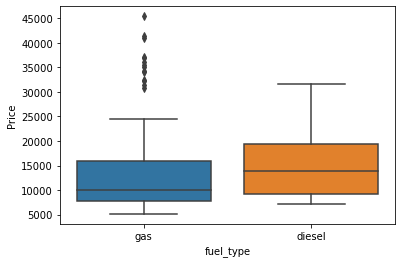

In [3]:
#A/B TEST
sns.boxplot(x='fueltype', y='price', data = data)
plt.xlabel('fuel_type')
plt.ylabel('Price')
#plt.suptitle('')

In [4]:
def plot2(cat,val,data):
    ax = sns.boxplot(x=cat,y=val, data = data)
    plt.xlabel(cat)
    plt.ylabel(val)
    return ax

<AxesSubplot:xlabel='aspiration', ylabel='price'>

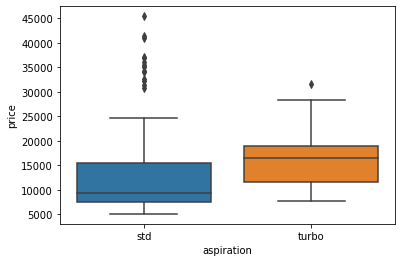

In [5]:
plot2('aspiration', 'price', data)

<AxesSubplot:xlabel='doornumber', ylabel='price'>

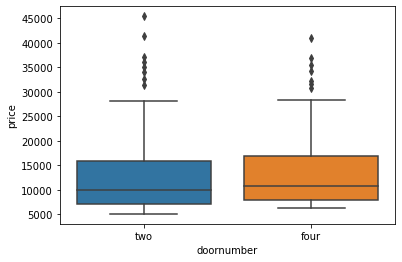

In [6]:
plot2('doornumber','price',data)

<AxesSubplot:xlabel='enginelocation', ylabel='price'>

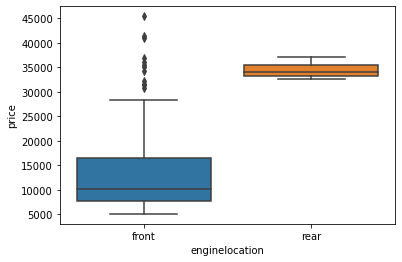

In [7]:
plot2('enginelocation','price', data)

In [8]:
def observeddiff (col, val, data):
    data = data[[col, val]]
    newData = data.groupby(col).mean(val)
    a = newData[val].iloc[0]
    b = newData[val].iloc[1]
    if a >b:
        mean_diff = a-b
    else:
        mean_diff = b-a
    return mean_diff

In [9]:
#data.info()

fueltype_diff = observeddiff('enginelocation', 'price', data)

In [10]:
#defining a permutation function for A/B testing
import random
def permfunc (df, col, val):
    df = df[[col, val]]
    categories = df[col].value_counts()
    nA = categories.iloc[0]
    nB = categories.iloc[1]
    n = nA + nB
    idxA = set(random.sample(range(n), nA))
    idxB = set(range(n)) - idxA
    meanB = df.loc[idxB].mean()
    meanA = df.loc[idxA].mean()
    permmeandiff = abs(meanA - meanB)
    return permmeandiff

In [11]:
perm_diffs = [permfunc(data, 'fueltype', 'price') for _ in range(1000)]

In [12]:
perm_diffs = pd.DataFrame(perm_diffs)
#sns.histplot(data = perm_diffs,  bins = 10)
#plt.vlines(x= fueltype_diff, colors='blue')

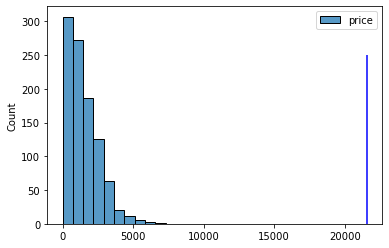

In [13]:
sns.histplot(data = perm_diffs,  bins = 10)
plt.vlines(x= fueltype_diff, ymin = 0, ymax =250, colors='blue')

In [14]:
pvalue = np.mean(perm_diffs > fueltype_diff)
pvalue

price    0.0
dtype: float64

The pvalue obtained suggest that fuel type is a statistically significant feature and is likely a contributing
factor to the price of a car.

In [15]:
asp_diff = observeddiff('aspiration','price',data)

In [16]:
asp_perm = [permfunc(data, 'aspiration','price') for _ in range(1000)]

In [17]:
asp_perm = pd.DataFrame(asp_perm)

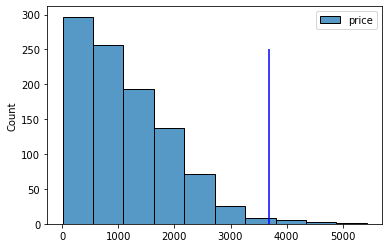

In [18]:
sns.histplot(data = asp_perm,  bins = 10)
plt.vlines(x= asp_diff, ymin = 0, ymax =250, colors='blue')

In [19]:
pvalue_asp = np.mean(asp_perm > asp_diff)

In [20]:
pvalue_asp

price    0.011
dtype: float64

In [21]:
doornum_diff = observeddiff('doornumber','price', data)

In [22]:
doornum_perm = [permfunc(data, 'doornumber', 'price') for _ in range(1000)]

In [23]:
doornum_perm = pd.DataFrame(doornum_perm)

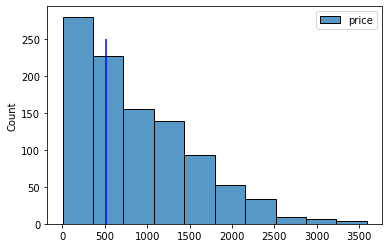

In [24]:
sns.histplot(data = doornum_perm,  bins = 10)
plt.vlines(x= doornum_diff, ymin = 0, ymax =250, colors='blue')

In [25]:
pvalue_doornum = np.mean(doornum_perm>doornum_diff)
pvalue_doornum

price    0.63
dtype: float64

In [26]:
engloc_diff = observeddiff('enginelocation', 'price', data)

In [27]:
engloc_perm = [permfunc(data, 'enginelocation','price') for _ in range(1000)]

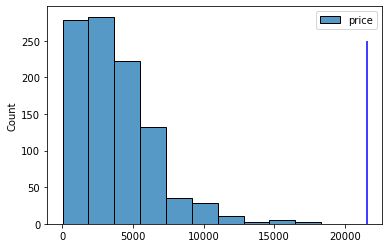

In [28]:
engloc_perm = pd.DataFrame(engloc_perm)
sns.histplot(data = engloc_perm,  bins = 10)
plt.vlines(x= engloc_diff, ymin = 0, ymax =250, colors='blue')

In [29]:
pvalue_engloc = np.mean(engloc_perm > engloc_diff)
pvalue_engloc

price    0.0
dtype: float64

# ANOVA

In [30]:
anovaCatList = ['carbody','drivewheel','enginetype','cylindernumber','fuelsystem']

In [31]:

def observedMV(var,df, par):
        df = df[[var, par]]
        mean = []
        va = []
        df = df.groupby(var)
        means = df[par].mean()
        vars = df[par].mean().var()
        mean.append(means)
        va.append(vars)
        return {'means':mean, 'variance':va}

In [32]:
parameters = {anovaCatList[i] : observedMV(anovaCatList[i], data, 'price') for i in range(len(anovaCatList))}
    

In [33]:
parameters

{'carbody': {'means': [carbody
   convertible    21890.500000
   hardtop        22208.500000
   hatchback      10376.652386
   sedan          14344.270833
   wagon          12371.960000
   Name: price, dtype: float64],
  'variance': [30121374.271118518]},
 'drivewheel': {'means': [drivewheel
   4wd    11087.463000
   fwd     9239.308333
   rwd    19910.809211
   Name: price, dtype: float64],
  'variance': [32524674.165776923]},
 'enginetype': {'means': [enginetype
   dohc     18116.416667
   dohcv    31400.500000
   l        14627.583333
   ohc      11574.048426
   ohcf     13738.600000
   ohcv     25098.384615
   rotor    13020.000000
   Name: price, dtype: float64],
  'variance': [54207563.3497186]},
 'cylindernumber': {'means': [cylindernumber
   eight     37400.100000
   five      21630.469727
   four      10285.754717
   six       23671.833333
   three      5151.000000
   twelve    36000.000000
   two       13020.000000
   Name: price, dtype: float64],
  'variance': [155193683.281

In [34]:
observed_parameters = pd.DataFrame(parameters)

In [35]:
'''
def perm_test(df)
df = df.copy()
df['Time'] = np.random.permutation(df['Time'].values)
return df.groupby('Page').mean().var()[0]
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))
'''

"\ndef perm_test(df)\ndf = df.copy()\ndf['Time'] = np.random.permutation(df['Time'].values)\nreturn df.groupby('Page').mean().var()[0]\nperm_variance = [perm_test(four_sessions) for _ in range(3000)]\nprint('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))\n"

In [36]:
def permtest(df,var,val):
    df[var] = np.random.permutation(df[var].values)
    variance = df.groupby(var)[val].mean().var()
    return variance

ANOVA for carbody

<AxesSubplot:xlabel='carbody', ylabel='price'>

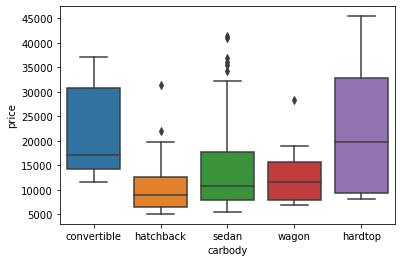

In [37]:
#plotting the distribution of values per each category in each feature
plot2('carbody', 'price', data)

In [38]:
carbody_perm_variance = [permtest(data, 'carbody', 'price') for _ in range(3000)]

In [42]:
carbody_obs_variance = observed_parameters['carbody']['variance'][0]

In [43]:
carbody_obs_variance

30121374.271118518

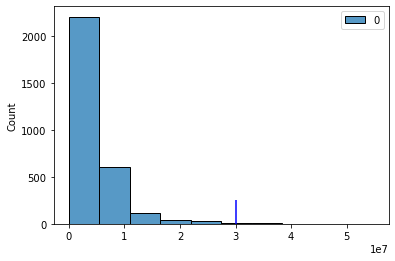

In [45]:
carbody_perm_variance = pd.DataFrame(carbody_perm_variance)
sns.histplot(data = carbody_perm_variance,  bins = 10)
plt.vlines(x= carbody_obs_variance, ymin = 0, ymax =250, colors='blue')

In [46]:
pvalue_carbody = np.mean(carbody_perm_variance > carbody_obs_variance)
pvalue_carbody

0    0.003333
dtype: float64

ANOVA for drivewheel

<AxesSubplot:xlabel='drivewheel', ylabel='price'>

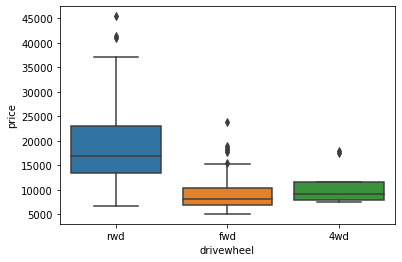

In [47]:
plot2('drivewheel','price',data)

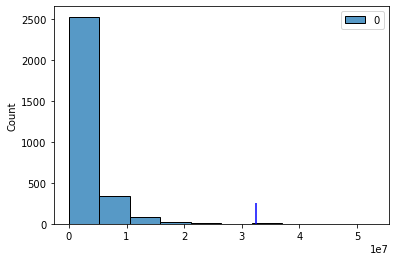

In [48]:
drivewheel_perm_variance = [permtest(data, 'drivewheel', 'price') for _ in range(3000)]
drivewheel_obs_variance = observed_parameters['drivewheel']['variance'][0]
drivewheel_perm_variance = pd.DataFrame(drivewheel_perm_variance)
sns.histplot(data = drivewheel_perm_variance,  bins = 10)
plt.vlines(x= drivewheel_obs_variance, ymin = 0, ymax =250, colors='blue')

In [49]:
pvalue_drivewheel = np.mean(carbody_perm_variance > carbody_obs_variance)
pvalue_drivewheel

0    0.003333
dtype: float64

ANOVA for enginetype

<AxesSubplot:xlabel='enginetype', ylabel='price'>

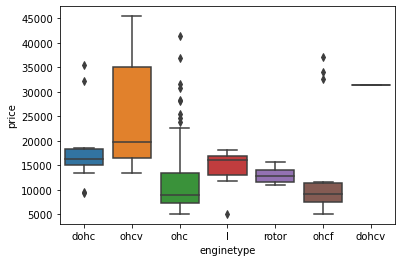

In [52]:
plot2('enginetype', 'price', data)

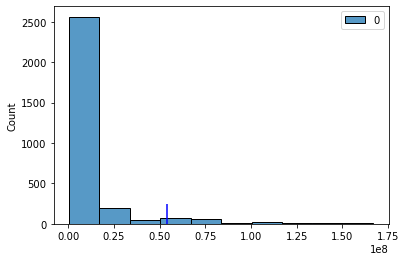

In [53]:
enginetype_perm_variance = [permtest(data, 'enginetype', 'price') for _ in range(3000)]
enginetype_obs_variance = observed_parameters['enginetype']['variance'][0]
enginetype_perm_variance = pd.DataFrame(enginetype_perm_variance)
sns.histplot(data = enginetype_perm_variance,  bins = 10)
plt.vlines(x= enginetype_obs_variance, ymin = 0, ymax =250, colors='blue')

In [54]:
pvalue_enginetype = np.mean(enginetype_perm_variance > enginetype_obs_variance)
pvalue_enginetype

0    0.054667
dtype: float64

ANOVA for cylindernumber 

<AxesSubplot:xlabel='cylindernumber', ylabel='price'>

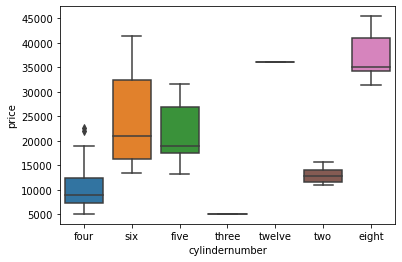

In [55]:
plot2('cylindernumber', 'price', data)

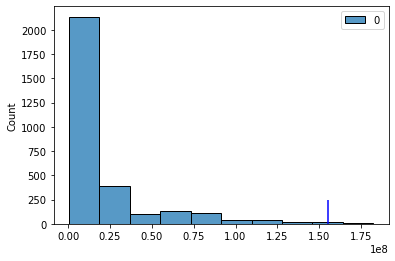

In [56]:
cylindernumber_perm_variance = [permtest(data, 'cylindernumber', 'price') for _ in range(3000)]
cylindernumber_obs_variance = observed_parameters['cylindernumber']['variance'][0]
cylindernumber_perm_variance = pd.DataFrame(cylindernumber_perm_variance)
sns.histplot(data = cylindernumber_perm_variance,  bins = 10)
plt.vlines(x= cylindernumber_obs_variance, ymin = 0, ymax =250, colors='blue')

In [57]:
pvalue_cylindernumber = np.mean(cylindernumber_perm_variance > cylindernumber_obs_variance)
pvalue_cylindernumber

0    0.005333
dtype: float64

ANOVA for fuelsystem

<AxesSubplot:xlabel='fuelsystem', ylabel='price'>

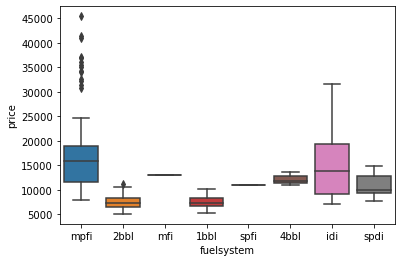

In [58]:
plot2('fuelsystem','price',data)

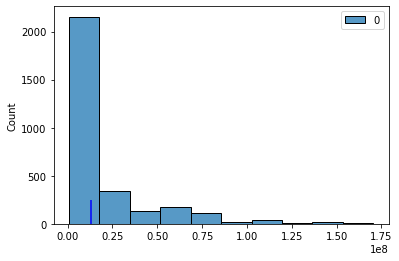

In [59]:
fuelsystem_perm_variance = [permtest(data, 'fuelsystem', 'price') for _ in range(3000)]
fuelsystem_obs_variance = observed_parameters['fuelsystem']['variance'][0]
fuelsystem_perm_variance = pd.DataFrame(fuelsystem_perm_variance)
sns.histplot(data = fuelsystem_perm_variance,  bins = 10)
plt.vlines(x= fuelsystem_obs_variance, ymin = 0, ymax =250, colors='blue')

In [60]:
pvalue_fuelsystem = np.mean(fuelsystem_perm_variance > fuelsystem_obs_variance)
pvalue_fuelsystem

0    0.409667
dtype: float64

In [62]:
#features with pvalues > 0.05 are statistically insignificant and will be dropped from the model
drop_features = ['fuelsystem', 'enginetype','doornumber']

# EDA

In [72]:
data.head()

,Unnamed: 0,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,carbrand
0,0,1,3,alfa-romero giulia,gas,std,two,sedan,rwd,front,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,alfa-romero
1,1,2,3,alfa-romero stelvio,gas,std,two,hatchback,fwd,front,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,alfa-romero
2,2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,alfa-romero
3,3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,...,spdi,3.19,3.40,10.0,102,5500,24,30,13950.0,audi
4,4,5,2,audi 100ls,gas,std,four,hatchback,fwd,front,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,audi


In [66]:
data_numerical = data.select_dtypes(exclude='object', )

In [67]:
data_numerical.head()

,Unnamed: 0,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,0,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,1,2,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,2,3,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,3,4,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,4,5,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


In [74]:
data_numerical = data_numerical.drop(['Unnamed: 0', 'car_ID' ], axis=1)

In [75]:
data_numerical['symboling'].value_counts()

 0    67
 1    54
 2    32
 3    27
-1    22
-2     3
Name: symboling, dtype: int64

<AxesSubplot:xlabel='symboling', ylabel='price'>

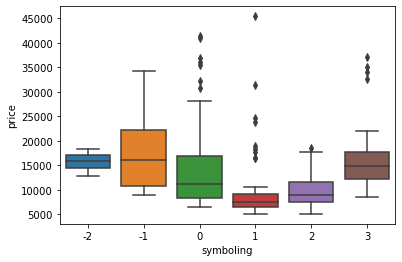

In [80]:
sns.boxplot(x= 'symboling', y='price', data=data_numerical)

In [81]:
data_corr = data_numerical.drop('symboling', axis=1)

In [82]:
corr = data_corr.corr()

<AxesSubplot:>

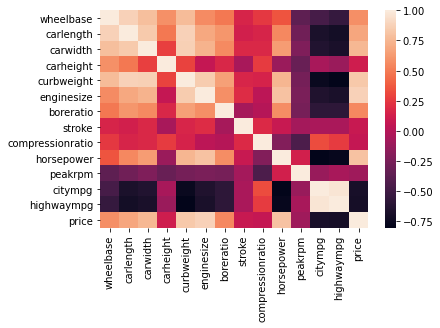

In [83]:
sns.heatmap(corr)

In [85]:
corr['price']

wheelbase           0.577816
carlength           0.682920
carwidth            0.759325
carheight           0.119336
curbweight          0.835305
enginesize          0.874145
boreratio           0.553173
stroke              0.079443
compressionratio    0.067984
horsepower          0.808139
peakrpm            -0.085267
citympg            -0.685751
highwaympg         -0.697599
price               1.000000
Name: price, dtype: float64

In [ ]:
#assessment